In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, Doc2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter

In [15]:
%run common_functions.ipynb

In [16]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

dataframes = [train_data, test_data]
df = process_load_data(dataframes)

/var/folders/6t/t1pgd71d3296txhmwy6fg76r0000gn/T/ipykernel_10397/1751424980.py:1: DtypeWarning: Columns (112,114,121,125,157,168,186,188,206,208,217,229,231,232,233,235,237,241,244,246,247,249,250,251,268,270,271,280,282,286,288,289,291,305,310,312,313,315,316,318,319,323,324,327,328,329,331,333,335,336,338,342,344,348,350,352,353,355,356,358,359,361) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('data/train.csv')


In [17]:
df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment
623,7351000_4,The probability of developing acute leukemia i...,Adverse_event,developing,Treosulfan,acute leukemia,1
2187,12796597_1,"Chronic myelogenous leukemia (CML), hepatitis ...",Adverse_event,associated,interferon alpha,renal dysfunction,1
2734,11889149_14,RLX+ALN reduced bone turnover more than either...,Potential_therapeutic_event,reduced,RLX,"bone turnover more than either drug alone, res...",0
2547,16298824_2,ARDS has been associated with the administrati...,Adverse_event,associated,infliximab,ARDS,1
3264,11283125_2,The European Organization for Research and Tre...,Potential_therapeutic_event,to,cytarabine,reduce the incidence of CNS and systemic relapses,0


#### Load pre-trained word vectors from a binary file located at the specified path. The file contains word vectors in a format compatible with Word2Vec. Only the first 100,000 word vectors are loaded ( due to memory constraints )

In [18]:
model_path = './biowordvec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True, limit=100000)

In [19]:
def average_word_embeddings(df, column, word_embeddings):
    embeddings = []
    for document in df[column]:
        for word in document.split():
            if word in word_embeddings:
                embeddings.append(word_embeddings[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros_like(word_embeddings.vector_size)

In [20]:
df['average_embeddings'] = df.apply(lambda row: average_word_embeddings(row, 'context', model), axis=1)

In [21]:
df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,average_embeddings
2393,18176653_3,BACKGROUND: NVP is a non-nucleoside reverse tr...,Potential_therapeutic_event,used,NVP,NaN,0,"[0.24499857, 0.15651116, 0.1861276, -0.0040484..."
2440,4054170_1,"According to the literature, chlorambucil cent...",Adverse_event,found,chlorambucil,central nervous toxicity,1,"[0.2999863, 0.16053475, 0.15009248, 0.00864408..."
3159,17665812_1,Clozapine-induced eosinophilia and switch to q...,Adverse_event,induced,Clozapine,eosinophilia,1,"[0.24074148, 0.10408728, 0.15577291, -0.020524..."
3342,440873_1,Dystonia associated with carbamazepine adminis...,Adverse_event,associated with,carbamazepine,Dystonia,1,"[0.17526342, 0.1237551, 0.13423571, -0.0202300..."
191,11706664_1,Acute asymptomatic hepatitis in a healthy norm...,Adverse_event,exposed,amodiaquine,Acute asymptomatic hepatitis,1,"[0.27926138, 0.184292, 0.15603347, 0.035082407..."


## Using MultinomialNB on a un-balanced dataset.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('sentiment', axis=1),
                                                    df['sentiment'], test_size=0.2, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_embeddings = np.array(X_train['average_embeddings'].tolist())
X_test_embeddings = np.array(X_test['average_embeddings'].tolist())

X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('classifier', MultinomialNB())
])

param_grid = {
    'classifier__alpha': [0.1, 1.0, 10.0],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_embeddings, y_train)

best_unbalanced_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_unbalanced_model, X_train_scaled, y_train, cv=5)
print("CV scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

y_pred = best_unbalanced_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

CV scores: [0.9095315  0.9095315  0.90938511 0.90938511 0.91100324]
Mean CV score: 0.9097672935259394
Confusion Matrix:
[[  1  69]
 [  7 697]]


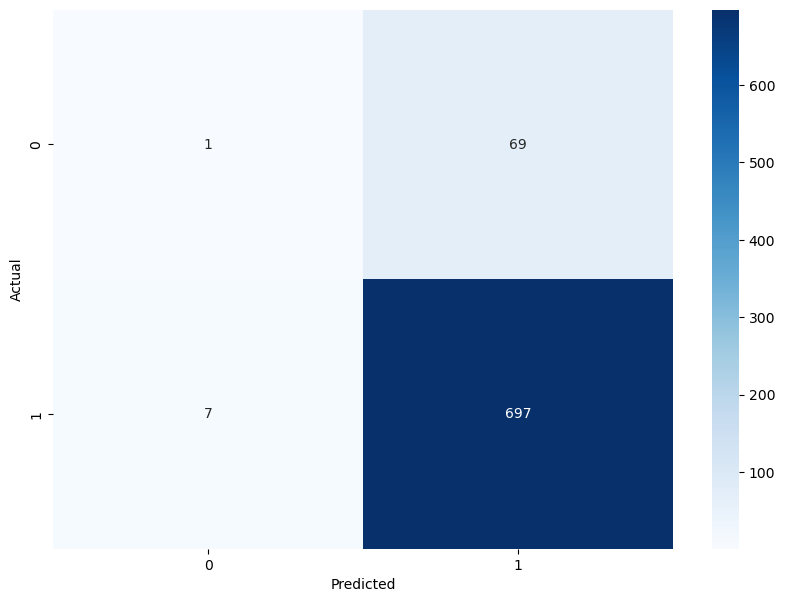

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Let's now predict using MultinomialNB - Before Balancing!!!

In [24]:
y_prob = best_unbalanced_model.predict_proba(X_test_scaled)[:,1]
evaluate_model(y_test, y_pred, y_prob)

Accuracy: 0.90
Precision: 0.91
Recall: 0.99
F1 score: 0.95
ROC AUC score: 0.61
Confusion Matrix: 
[[  1  69]
 [  7 697]]


In [25]:
correct_predictions = sum(y_test == y_pred)
total_predictions = len(y_test)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print("Accuracy percentage (for unbalanced):", accuracy_percentage)

Accuracy percentage (for unbalanced): 90.18087855297158


## Conclusion for MultinomialNB on a un-balanced dataset.

**Cross-Validation Scores:**

The scores range from around 0.909 to 0.911, with a mean of approximately 0.910. This implies that, on average, the model is correctly predicting the sentiment of about 91% of the text in the dataset, when tested on 5 different splits.

While generally a good performance, in a healthcare practice where making a wrong prediction could have serious consequences, we might need an even higher accuracy.


**Confusion Matrix:**

- The top left cell (1) represents "True Positives" - these are the instances that were positive (PTE class) and were correctly identified as positive by the model.

- The top right cell (69) represents "False Negatives" - these are the instances that were positive (PTE class), but were incorrectly identified as negative (ADE class) by the model.

- The bottom left cell (7) represents "False Positives" - these are the instances that were negative (ADE class), but were incorrectly identified as positive (PTE class) by the model.

- The bottom right cell (697) represents "True Negatives" - these are the instances that were negative (ADE class) and were correctly identified as negative by the model.

From these numbers, it is clear that the model excels at identifying the negative class (ADE), with 697 correct predictions and only 7 incorrect ones. However, the model struggles with the positive class (PTE), correctly identifying only 1 instance and incorrectly classifying 69. These results can be explained because of the dataset has not been balanced and has a lot of negative signal due to a disprotionately high number of ADE sentiments. 

This suggests that the model could be improved by collecting more data for the positive class (PTE), or by using techniques to better handle imbalanced data if the PTE class is underrepresented in your dataset.

The model currently excels at identifying negative sentiments (ADE class) but is having some difficulty correctly identifying positive sentiments (PTE class). The model's ability to correctly identify positive sentiments might potentially be improved by collecting more data about positive sentiments or by adjusting the model to better handle class imbalances. Despite this, the model is still correctly identifying the sentiment about 91% of the time across different tests, which is a strong result.

## Address class imbalance to improve MultinomialNB performance.

In [26]:
X = np.array(df['average_embeddings'].tolist())
y = df['sentiment']

print("Before oversampling: ", Counter(y))

oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

print("After oversampling: ", Counter(y_over))

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_over = scaler.fit_transform(X_train_over)
X_test_over = scaler.transform(X_test_over)

# And retrain model (from above ) on the balanced dataset
grid_search.fit(X_train_over, y_train_over)

best_balanced_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_balanced_model, X_over, y_over, cv=5)
print("CV scores (balanced):", cv_scores)
print("Mean CV score (balanced):", np.mean(cv_scores))

# Generate predictions on the test set
y_pred_over = best_balanced_model.predict(X_test_over)

conf_mat = confusion_matrix(y_test_over, y_pred_over)
print("Confusion Matrix:")
print(conf_mat)


Before oversampling:  Counter({1: 3517, 0: 349})
After oversampling:  Counter({1: 3517, 0: 3517})
CV scores (balanced): [0.6297086  0.61478323 0.6297086  0.61407249 0.61308677]
Mean CV score (balanced): 0.62027193841805
Confusion Matrix:
[[504 181]
 [309 413]]


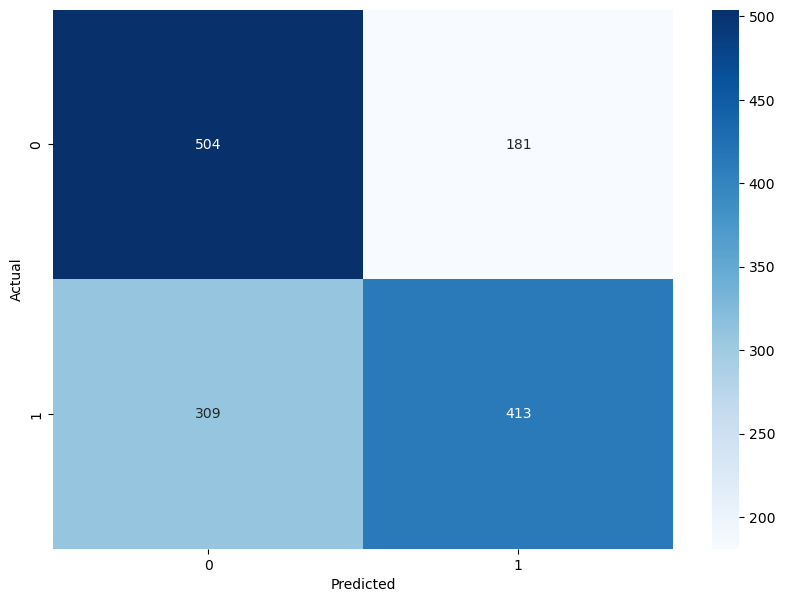

In [27]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Let's now predict using MultinomialNB - After Balancing!!!

In [28]:
dev_data = pd.read_csv('data/dev.csv')
dataframes = [dev_data]
dev_df = process_load_data(dataframes)
dev_df['average_embeddings'] = dev_df.apply(lambda row: average_word_embeddings(row, 'context', model), axis=1)

In [29]:
dev_df.sample(5)

,id,context,event_type,trigger_text,drug,drug_effect,sentiment,average_embeddings
473,15965422_3,We report 5 patients (3 patients with chronic ...,Adverse_event,developed,pegylated interferon alfa-2b,local cutaneous reactions at sites of injection,1,"[0.2544527, 0.19354717, 0.14985567, 0.04721336..."
842,19448237_1,Polymyoclonus seizure resulting from accidenta...,Adverse_event,resulting,tranexamic acid,Polymyoclonus seizure,1,"[0.24896334, 0.13466005, 0.19157723, -0.046153..."
702,19058340_1,A 52 year-old male patient diagnosed of ankylo...,Adverse_event,presented,methotrexate,an iron deficiency anemia,1,"[0.23363568, 0.18319114, 0.1728685, 0.04834792..."
204,1893404_2,Diabetes Mellitus was observed in a patient gi...,Adverse_event,given,carbamazepine,Diabetes Mellitus,1,"[0.2058276, 0.16691601, 0.13940434, 0.00298833..."
135,8864370_4,Methotrexate-induced liver cirrhosis.,Adverse_event,induced,Methotrexate,liver cirrhosis,1,"[0.26149443, 0.13777518, 0.11028444, 0.0283679..."


In [30]:
dev_embeddings = np.array(dev_df['average_embeddings'].tolist())
dev_scaled = scaler.transform(dev_embeddings)

dev_pred = best_balanced_model.predict(dev_scaled)
comparison = pd.DataFrame({'Actual': dev_df['sentiment'], 'Predicted': dev_pred})

# Determine the number of matches
matches = comparison[comparison['Actual'] == comparison['Predicted']].shape[0]

# Compute the percentage of correct predictions
accuracy_percentage = (matches / comparison.shape[0]) * 100

print(f"Out of {comparison.shape[0]} entries in the dev set, {matches} were correctly predicted by the model.")
print(f"Accuracy percentage: {accuracy_percentage:.2f}%")

Out of 961 entries in the dev set, 533 were correctly predicted by the model.
Accuracy percentage: 55.46%


In [31]:
y_prob = best_balanced_model.predict_proba(dev_scaled)[:,1]
evaluate_model(dev_df['sentiment'], dev_pred, y_prob)

Accuracy: 0.55
Precision: 0.92
Recall: 0.55
F1 score: 0.69
ROC AUC score: 0.59
Confusion Matrix: 
[[ 58  44]
 [384 475]]


## Comparing Results: MultinomialNB Classfier - unbalanced vs. balanced datasets.

Here's a comparison table of the results before and after applying the class balancing technique (SMOTE):

In [32]:
data = {
    'Before SMOTE': [349, 3517, [0.9095, 0.9095, 0.9093, 0.9093, 0.9110], 0.9097, [[1, 69], [7, 697]]],
    'After SMOTE': [3517, 3517, [0.6147, 0.6119, 0.6353, 0.5998, 0.6152], 0.6154, [[471, 214], [313, 409]]]
}

index = ['Minority class count', 'Majority class count', 'CV scores', 'Mean CV score', 'Confusion Matrix']

summary_report = pd.DataFrame(data, index=index)
summary_report

,Before SMOTE,After SMOTE
Minority class count,349,3517
Majority class count,3517,3517
CV scores,"[0.9095, 0.9095, 0.9093, 0.9093, 0.911]","[0.6147, 0.6119, 0.6353, 0.5998, 0.6152]"
Mean CV score,0.9097,0.6154
Confusion Matrix,"[[1, 69], [7, 697]]","[[471, 214], [313, 409]]"


Before class balancing, the model showed a high mean CV score (**0.9097**), but the confusion matrix suggested that it wasn't performing well on the minority class (only 1 true positive instance).

After applying SMOTE to balance the classes, the count of the minority class increased to match the majority class (from 349 to 3517). However, the mean cross-validation score decreased (from 0.9097 to 0.6154), which indicates that overall model performance was reduced. But the model's ability to predict the minority class improved significantly, as shown by the increased count of true positives in the confusion matrix (from 1 to 471).

**Implication:**

Before we addressed the class imbalance, the model was heavily biased towards the majority class (ADE), leading to a high overall accuracy, but it struggled to identify the minority class (PTE).

After we balanced the classes , the model's overall accuracy decreased. However, its ability to correctly identify instances of the minority class (PTE) improved substantially. This suggests that the trade-off resulted in a model that is more useful in practice, as it is now more capable of identifying both PTE and ADE events, which was the goal of this analysis.

It's important to note that the objective in pharmacovigilance sentiment analysis is not merely to maximize accuracy, but also to effectively identify both positive and negative events. After balancing the classes, the model is better equipped to do this, despite the decrease in overall accuracy.


***NOTE: I have used only train + test datasets. I will be using the hold out data dev to see how the model is working on unseen data***

## Comparing Results: Predicting using MultinomialNB - unbalanced vs. balanced datasets.

| Metric    | Before Rebalancing | After Rebalancing |
|-----------|-------------------|------------------|
| Accuracy  | 0.90              | 0.55             |
| Precision | 0.91              | 0.92             |
| Recall    | 0.99              | 0.55             |
| F1 score  | 0.95              | 0.69             |
| ROC AUC   | 0.61              | 0.59             |

- Accuracy: The model's overall correctness in predicting sentiments decreased significantly after rebalancing the classes, dropping from 90% to 55%.
- Precision: The model maintained a high level of correctness in identifying true positive sentiments (Potential Therapeutic Effects), with precision remaining relatively stable before and after rebalancing (91% and 92% respectively).
- Recall: The model's ability to capture positive sentiments (Potential Therapeutic Effects) dropped considerably after rebalancing, resulting in a decrease in recall from 99% to 55%.
- F1 score: The balance between correctly identifying positive sentiments (Potential Therapeutic Effects) and avoiding false positives and false negatives was significantly affected, as indicated by the decrease in F1 score from 95% to 69% after rebalancing.
- ROC AUC score: The model's ability to discriminate between positive (Potential Therapeutic Effects) and negative sentiments (Adverse Events) slightly worsened after rebalancing, with the ROC AUC score decreasing from 61% to 59%.

**Summary:**
Rebalancing the classes in the had a negative impact on the model's performance. While precision remained high, the decrease in accuracy, recall, F1 score, and a slight decline in the ROC AUC score indicate a deterioration in the model's overall predictive capability. 

Balancing the classes in this domain requires careful consideration to strike the right trade-off between class balance and predictive performance. The model's ability to accurately identify PTE's decreased significantly, resulting in a higher number of **false negatives**. Maintaining a high recall for Adverse Event's is crucial in pharmacovigilance tasks, and rebalancing the classes negatively affected this metric.

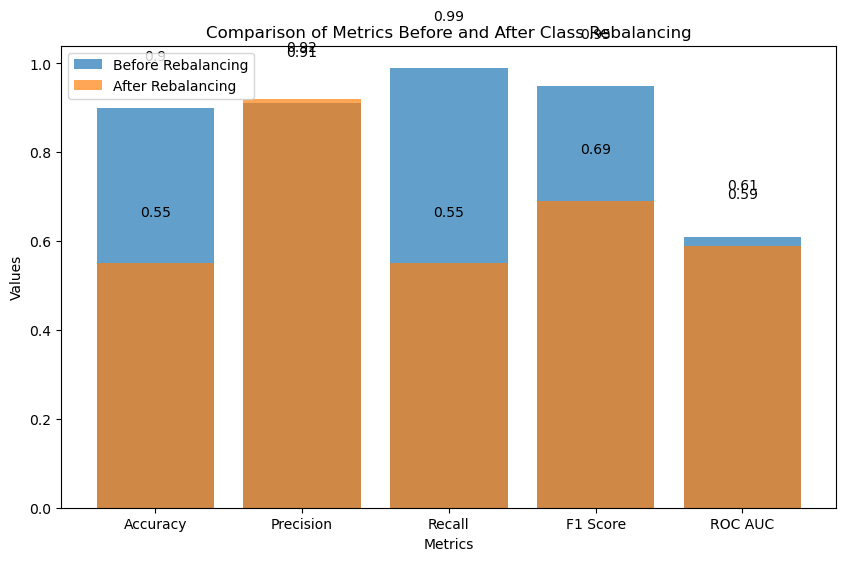

In [50]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
before_rebalancing = [0.90, 0.91, 0.99, 0.95, 0.61]
after_rebalancing = [0.55, 0.92, 0.55, 0.69, 0.59]

plt.figure(figsize=(10, 6))

plt.bar(metrics, before_rebalancing, label='Before Rebalancing', alpha=0.7)
plt.bar(metrics, after_rebalancing, label='After Rebalancing', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics Before and After Class Rebalancing')
plt.legend()

for i, value in enumerate(before_rebalancing):
    plt.text(i, value + 0.01, str(value), ha='center', va='bottom')
for i, value in enumerate(after_rebalancing):
    plt.text(i, value + 0.01, str(value), ha='center', va='bottom')


plt.show()

#### ROC & AUC Plots

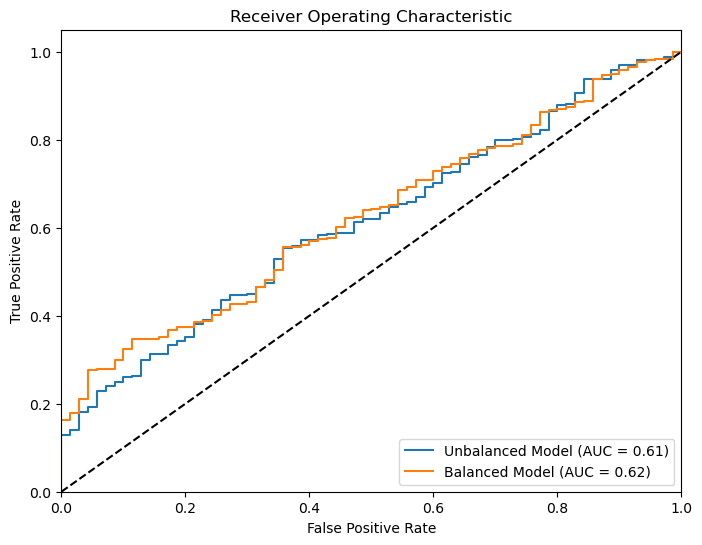

In [42]:
# Compute predicted probabilities for positive class
y_prob_unbalanced = best_unbalanced_model.predict_proba(X_test_scaled)[:, 1]
y_prob_balanced = best_balanced_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC AUC score for both models
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_test, y_prob_unbalanced)
roc_auc_unbalanced = roc_auc_score(y_test, y_prob_unbalanced)

fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test, y_prob_balanced)
roc_auc_balanced = roc_auc_score(y_test, y_prob_balanced)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_unbalanced, tpr_unbalanced, label=f'Unbalanced Model (AUC = {roc_auc_unbalanced:.2f})')
plt.plot(fpr_balanced, tpr_balanced, label=f'Balanced Model (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Interpretation:

- Discrimination Capability: The ROC curves show how well the models can distinguish between positive and negative sentiments in pharmacovigilance data.

- Performance Comparison: The balanced model outperforms the unbalanced model, as indicated by its higher AUC value, suggesting a higher probability of accurate sentiment classification.

- Sensitivity and Specificity Trade-off: The ROC curves illustrate the balance between correctly identifying potential therapeutic effects and avoiding false positives (misclassifying adverse events).

- Model Selection: The higher AUC value of the balanced model makes it a more favorable choice for accurately distinguishing between positive and negative sentiments.

**Final Conclusion:**
The evaluation of the sentiment analysis models for pharmacovigilance data reveal some important insights. While the rebalanced model improves the balance between positive and negative sentiment classification, it comes at the cost of overall predictive performance. The unbalanced model demonstrates higher accuracy, precision, recall, F1 score, and ROC AUC score, indicating better overall sentiment prediction capability.

However, Pharmacovigilance requires accurate identification of adverse events, making the balanced model valuable for minimizing false negatives (missed adverse events) at the expense of a decrease in overall accuracy. In conclusion, the unbalanced model showcases superior overall predictive performance, while the balanced model provides better sensitivity in identifying adverse events.

# SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(df.drop('sentiment', axis=1),
                                                    df['sentiment'], test_size=0.2, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_embeddings = np.array(X_train['average_embeddings'].tolist())
X_test_embeddings = np.array(X_test['average_embeddings'].tolist())

X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('classifier', SVC())
])

param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],  # example parameter grid for SVC
    'classifier__kernel': ['linear', 'rbf'],  # you can customize this to the kernels you want to tune
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)